In [1]:
import numpy as np
from scipy.linalg import circulant
import scipy.signal as signal
from scipy.io.wavfile import read 
from IPython.display import Audio  
import wave
import struct
import matplotlib.pyplot as plt
fs=44100 #Frecuencia de  muestreo de archivos .wav

# Funciones

In [2]:
#Muestreamos el espectro del filtro peine para los 12 retrasos
def filter_coeffs(delays, t_60, alpha):
    element_1 = np.log(10) / 4
    element_2 = 1 - (1 / (alpha ** 2))
    g = np.zeros(len(delays))
    p = np.zeros(len(delays))
    for i in range(len(delays)):
        g[i] = 10 ** ((-3 * delays[i] * (1/fs)) / t_60)
    return p, g


def delay(input_signal, delay, gain = 1):
    output_signal = np.concatenate((np.zeros(delay), input_signal))[:input_signal.size]
    output_signal = output_signal * gain
    return output_signal

#señal de ceros con el filtro aplicado
def damping_filter(input_signal, p, g):
    B = np.array([g * (1 - p)])
    A = np.array([1, -p])
    output_signal = np.zeros(input_signal.shape)
    output_signal = signal.lfilter(B, A, input_signal)
    return output_signal

#Filtro de primer Orden IIR
def tonal_correction_filter(input_signal, alpha):
    beta = (1 - alpha)/(1 + alpha)
    E_nomin = np.array([1, -beta])
    E_denomin = np.array([1-beta])
    output_signal = np.zeros(input_signal.shape)
    output_signal = signal.lfilter(E_nomin, E_denomin, input_signal)
    return output_signal

# Main

In [3]:
delay_lens = np.array([601, 1399, 1747, 2269, 2707, 3089, 3323, 3571, 3911, 4127, 4639, 4999]) #Posiciones de los retrasos
num_delay_lines = delay_lens.shape[0]  #numero de retrasos Retrasos L=12

b = 1
c = 1

gain_b = np.full((num_delay_lines, 1), b)
gain_c = np.full((num_delay_lines, 2), c)

gain_c[1::2, 0] *= -1
gain_c[2::4, 1] *= -1
gain_c[3::4, 1] *= -1

init_delay = 0
gain_dry = 1 #Ganancia de la señal sin efecto
gain_wet = 0.2 #ganancia de la señal con efecto 
output_gain = 0.4 #mix de la señal wet y dry
alpha = 0.4 #Factor de la funcion de transferncia
t_60 = 1.5

p_coeffs, g_coeffs = filter_coeffs(delay_lens, t_60, alpha)
fm_gain = 1

#Matriz de feedback 
permutation_matrix = circulant(np.concatenate((np.array([0,1]), np.zeros(len(delay_lens)-2)))) 
N = permutation_matrix.shape[0]
u_vector = np.ones((N,1))
feedback_matrix = fm_gain * (permutation_matrix - np.matmul((2/N) * u_vector, u_vector.transpose()))

#abrimos el archivo (Wav estereo dos canales)
sample_in = 'james.wav'
frame_rate = 44100.0

wav_file = wave.open(sample_in, 'r')
num_samples_sample = wav_file.getnframes()
num_channels_sample = wav_file.getnchannels()
sample = wav_file.readframes(num_samples_sample)
total_samples_sample = num_samples_sample * num_channels_sample
wav_file.close()
    
sample = struct.unpack('{n}h'.format(n = total_samples_sample), sample)
sample = np.array([sample[0::2], sample[1::2]], dtype = np.float64)

#normalizamos los valores de cada canal
sample[0] /= np.max(np.abs(sample[0]), axis = 0)
sample[1] /= np.max(np.abs(sample[1]), axis = 0)
    
output_to_correct = np.zeros((sample.shape))
output_wet = np.zeros((sample.shape))

#aplicamos los reverbs a cada canal
    
for channel in range(2):
        
   

    sample_mx = np.tile(sample[channel,:], (num_delay_lines,1))
    sample_mx_out = np.zeros((sample_mx.shape))
    feedback_out_A = np.empty([num_delay_lines, sample_mx.shape[1]])
    feedback_out = np.zeros((feedback_out_A.shape))
    feedback_out_A = np.matmul(gain_b, sample[channel].reshape(1,sample.shape[1]))
        
    cnt = 0
    
    while True:
        for i in range(sample_mx.shape[0]):
            feedback_out_B = delay(feedback_out_A[i] + feedback_out[i], delay_lens[i])
            feedback_out_C = damping_filter(feedback_out_B, p_coeffs[i], g_coeffs[i]) 
            sample_mx_out[i] = feedback_out_C
                
        if np.array_equal(np.matmul(feedback_matrix, sample_mx_out), feedback_out):
            break
        cnt = cnt + 1
        feedback_out = np.matmul(feedback_matrix, sample_mx_out)

    
        
    output_to_correct[channel] = np.sum(sample_mx_out * gain_c[:, channel].reshape(gain_b.shape), axis = 0)
    output_wet[channel] = tonal_correction_filter(output_to_correct[channel], alpha)
    output_wet[channel] = delay(output_wet[channel], int(round(44.1 * init_delay)))
        
output = output_gain * (output_wet * gain_wet + (sample * gain_dry)).reshape(sample.shape)
        
#   El nuevo archivo con reverb  canal 1 y 2#
    
output_integer = np.zeros((output.shape))
output_integer[0] = (output[0]*int(np.iinfo(np.int16).max)).astype(np.int16)
output_integer[1] = (output[1]*int(np.iinfo(np.int16).max)).astype(np.int16)

signal_to_render = np.empty((output_integer[0].size * 2), dtype = np.int16)
signal_to_render[0::2] = output_integer[0]
signal_to_render[1::2] = output_integer[1]

#Para escribir el nuevo .wav
nframes_reverb = total_samples_sample
comptype = "NONE"
compname = "not compressed"
nchannels = 2
sampwidth = 2
    
wav_file_write = wave.open('reverbed.wav', 'w')
wav_file_write.setparams((nchannels, sampwidth, int(frame_rate), nframes_reverb, comptype, compname))

for s in range(nframes_reverb):
    wav_file_write.writeframes(struct.pack('h', signal_to_render[s]))
        
wav_file_write.close()




# Señal antes de aplicar el efecto (Dry) 


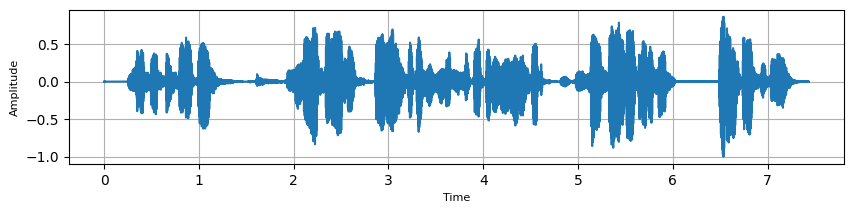

In [4]:
file_audio=('james.wav') 

fs, y=read(file_audio) # Cargar el archivo


x1=[]
for i in y:
    x1.append(i[0])

arr = np.array(x1)
arr=arr/float(max(abs(arr))) # escala la amplitud de la senal
t=np.arange(0, float(len(arr))/fs, 1.0/fs) # Vector de tiempo 
plt.figure(figsize=(10, 2))
plt.plot(t,arr) # Dibujar la grafica
plt.grid()


plt.xlabel('Time',fontsize=8) # Etiqueta eje X
plt.ylabel('Amplitude',fontsize=8) # Etiqueta eje Y
plt.show() # Mostrar la grafica
Audio(arr, rate=fs) # para escuchar la senal, si se desea

# Señal con reverb (WET)

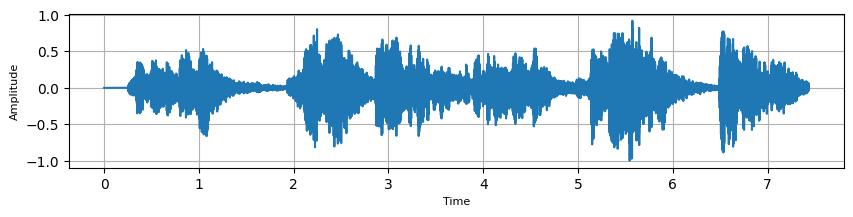

In [6]:
file_audio=('reverbed.wav') 

fs, y=read(file_audio) # Cargar el archivo


x1=[]
for i in y:
    x1.append(i[0])

arr1 = np.array(x1)
arr1=arr1/float(max(abs(arr1))) # escala la amplitud de la senal
t=np.arange(0, float(len(arr1))/fs, 1.0/fs) # Vector de tiempo 

plt.figure(figsize=(10, 2))
plt.plot(t,arr1) # Dibujar la grafica
plt.grid()


plt.xlabel('Time',fontsize=8) # Etiqueta eje X
plt.ylabel('Amplitude',fontsize=8) # Etiqueta eje Y
plt.show() # Mostrar la grafica
Audio(arr1, rate=fs) # para escuchar la senal, si se desea

# Espectros de las señales

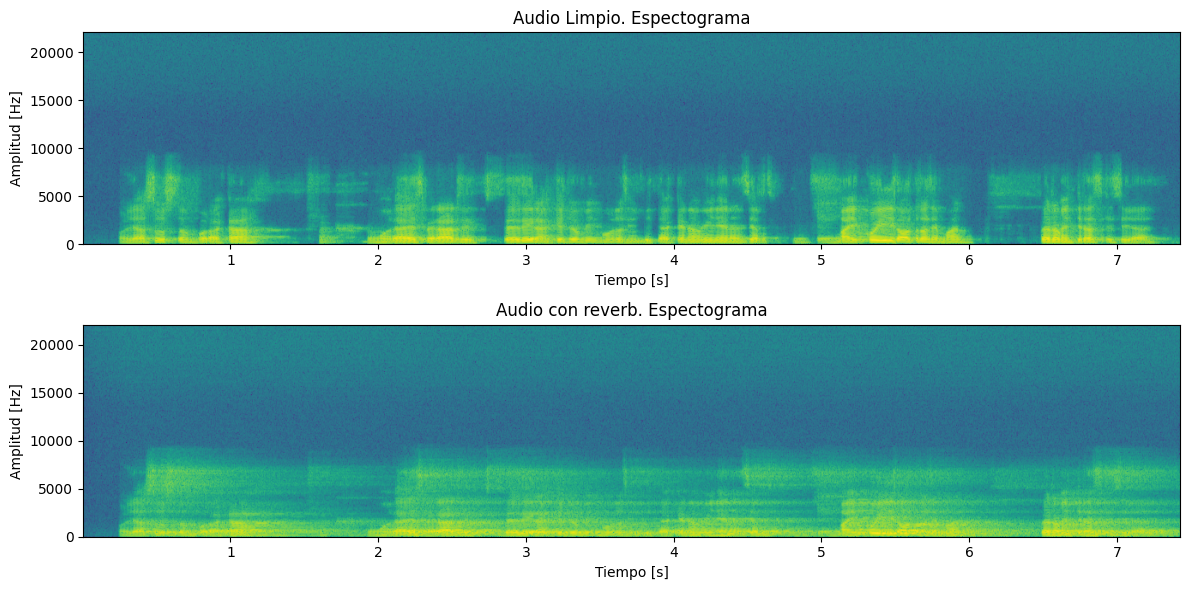

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
fig.patch.set_facecolor('white')

Pxx, freqs, bins, im = ax[0].specgram(arr, NFFT=1024//2, Fs=fs, noverlap=256)
ax[0].set_title('Audio Limpio. Espectograma')
ax[0].set_xlabel('Tiempo [s]')
ax[0].set_ylabel('Amplitud [Hz]')
ax[0].grid(False)

Pxx, freqs, bins, im = ax[1].specgram(arr1, NFFT=1024//2, Fs=fs, noverlap=256)
ax[1].set_title('Audio con reverb. Espectograma')
ax[1].set_xlabel('Tiempo [s]')
ax[1].set_ylabel('Amplitud [Hz]')
ax[1].grid(False)

plt.tight_layout()
plt.show();